### Key Concepts
* 各种分类方法，二分类，多分类，多抱歉分类
* 流程workflow
* 数据准备和数据分割，数据处理
* 非线性分类数据的激励函数的选择和实现
* layers：
  * input layer shape: in_features
  * hidden layers
  * Neurons per hidden layer
  * output layer shape: out_features
  * hidden layers activation: ReLU
  * output activation: sigmoid/sofmax
  * loss function: torch.nn.BCELoss/torch.nn.CrossEntropyLoss
  * optimizer: SGD,Adam in torch.optim

### Get data ready! 

In [1]:
# get data ready
# use sklearn make_circles()
from sklearn.datasets import make_circles
n_samples = 1000
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [4]:
# visualize the data
# make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [12]:
# check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

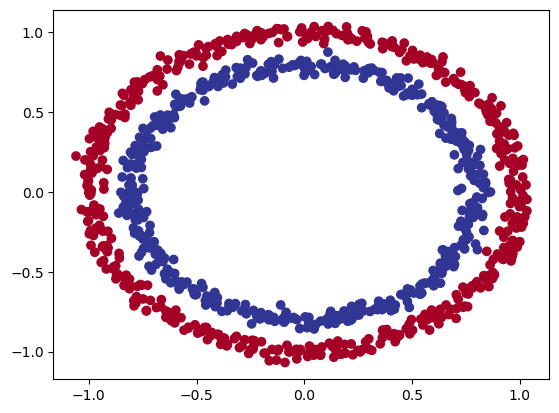

In [13]:
# visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [6]:
X.shape, y.shape # note that they are in different shape

((1000, 2), (1000,))

In [8]:
X[0], y[0] # the samples in different shape

(array([0.75424625, 0.23148074]), 1)

In [9]:
# turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
# view the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
# split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
len(X_train)

800

In [14]:
# build a model 
# standard Pytorch import
import torch
from torch import nn
# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Construct model

In [41]:
# construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

使用nn.Sequential也可以创建model，可以看出他也是一种流程型的，所以灵活性不如上面那种。

In [17]:
# another way to construct by nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [26]:
# make predictions with the model
untrained_preds = model_0(X_test.to(device))
untrained_preds[:5]

tensor([[0.7860],
        [0.8176],
        [0.6206],
        [0.8332],
        [0.4897]], grad_fn=<SliceBackward0>)

### Loss functions and optimizer

In [27]:
# create a loss function
loss_fn = nn.BCEWithLogitsLoss()
# create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

### Accuracy function

In [28]:
# calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [39]:
# check how the eq works by myself
import numpy as np
a = np.array([1, 1, 1, 1, 1, 1, 1])
a = torch.from_numpy(a).type(torch.float)
b = np.array([1, 1, 1, 1, 0, 1, 1])
b = torch.from_numpy(b).type(torch.float)
correct = torch.eq(a, b).sum().item()
correct

6

### how the forward pass works
logits -> prediction probabilities -> prediction labels

In [42]:
# view the first 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.4674],
        [0.2409],
        [0.7241],
        [0.3961],
        [0.1890]], grad_fn=<SliceBackward0>)

In [43]:
# use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6148],
        [0.5599],
        [0.6735],
        [0.5977],
        [0.5471]], grad_fn=<SigmoidBackward0>)

In [44]:
# find the label by round func
y_preds = torch.round(y_pred_probs)
y_preds

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<RoundBackward0>)

In [50]:
# put them together
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))
y_pred_labels.squeeze()[:5] # get rid of extra dimension

tensor([1., 1., 1., 1., 1.], grad_fn=<SliceBackward0>)

### Model training and test loops

In [53]:
torch.manual_seed(42)
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch:{epoch}|Loss:{loss:.5f},Accuracy:{acc:.2f}%|Test Loss:{test_loss:.5f},Test_Accuracy:{test_acc:.2f}%")

Epoch:0|Loss:0.72240,Accuracy:52.88%|Test Loss:0.71261,Test_Accuracy:57.00%
Epoch:10|Loss:0.72240,Accuracy:52.88%|Test Loss:0.71261,Test_Accuracy:57.00%
Epoch:20|Loss:0.72240,Accuracy:52.88%|Test Loss:0.71261,Test_Accuracy:57.00%
Epoch:30|Loss:0.72240,Accuracy:52.88%|Test Loss:0.71261,Test_Accuracy:57.00%
Epoch:40|Loss:0.72240,Accuracy:52.88%|Test Loss:0.71261,Test_Accuracy:57.00%
Epoch:50|Loss:0.72240,Accuracy:52.88%|Test Loss:0.71261,Test_Accuracy:57.00%
Epoch:60|Loss:0.72240,Accuracy:52.88%|Test Loss:0.71261,Test_Accuracy:57.00%
Epoch:70|Loss:0.72240,Accuracy:52.88%|Test Loss:0.71261,Test_Accuracy:57.00%
Epoch:80|Loss:0.72240,Accuracy:52.88%|Test Loss:0.71261,Test_Accuracy:57.00%
Epoch:90|Loss:0.72240,Accuracy:52.88%|Test Loss:0.71261,Test_Accuracy:57.00%


### Make predictions and evaluate

In [54]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

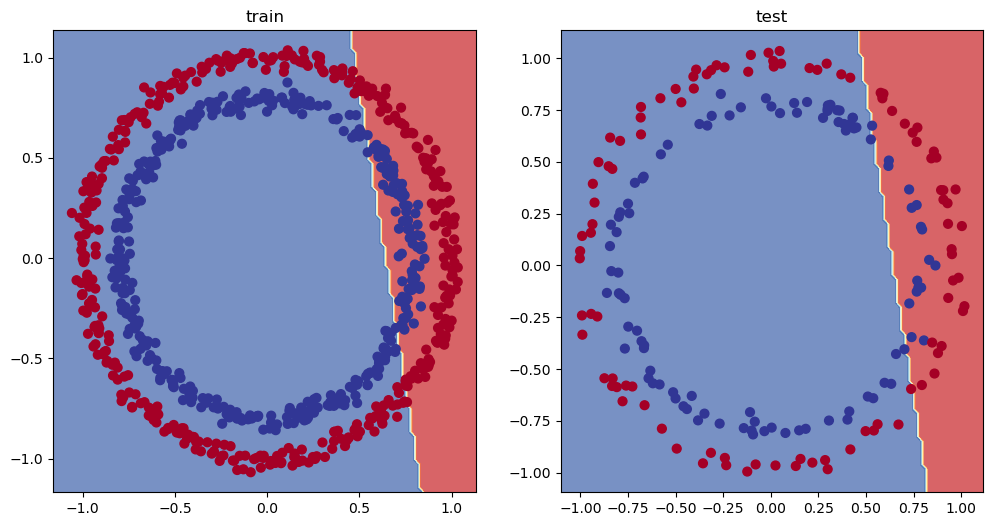

In [55]:
# plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_0, X_test, y_test)

### Improve a model from a model perspective
* add more layers
* add more hidden units
* fitting for longer
* change activation function
* change learning rate
* change loss function
* use transfer learning

In [56]:
# try sth
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [58]:
# loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)

In [59]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), y_train) if loss function is BCELoss()
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69369, Accuracy: 50.25% | Test loss: 0.69269, Test acc: 50.00%
Epoch: 200 | Loss: 0.69351, Accuracy: 50.12% | Test loss: 0.69282, Test acc: 49.50%
Epoch: 300 | Loss: 0.69339, Accuracy: 50.50% | Test loss: 0.69295, Test acc: 49.00%
Epoch: 400 | Loss: 0.69329, Accuracy: 50.38% | Test loss: 0.69309, Test acc: 48.50%
Epoch: 500 | Loss: 0.69322, Accuracy: 49.88% | Test loss: 0.69322, Test acc: 49.50%
Epoch: 600 | Loss: 0.69317, Accuracy: 49.50% | Test loss: 0.69335, Test acc: 53.00%
Epoch: 700 | Loss: 0.69313, Accuracy: 49.38% | Test loss: 0.69347, Test acc: 50.50%
Epoch: 800 | Loss: 0.69309, Accuracy: 50.00% | Test loss: 0.69358, Test acc: 51.00%
Epoch: 900 | Loss: 0.69307, Accuracy: 50.62% | Test loss: 0.69368, Test acc: 47.50%


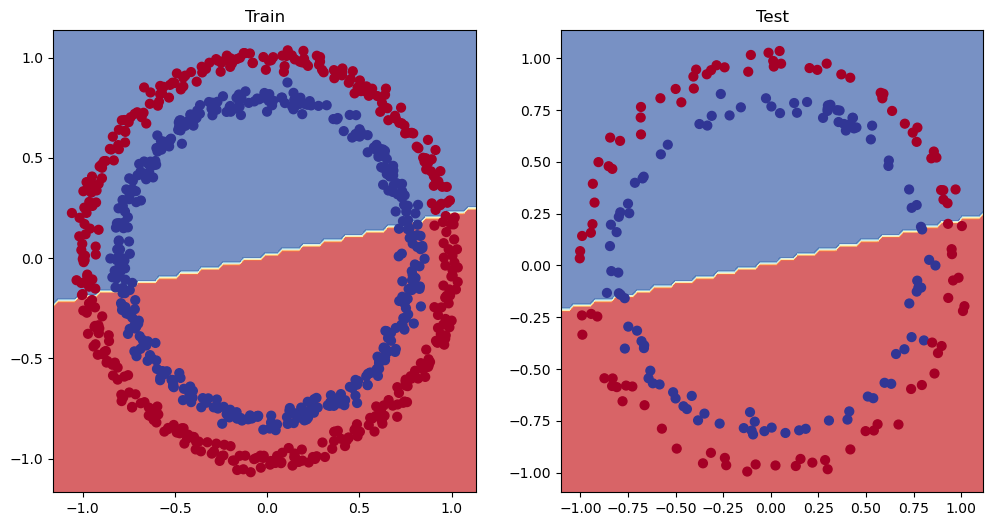

In [60]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### Linear and non-linear

In [61]:
# preparing data to see if the model can model a straight line
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [62]:
# create train and test split
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]
# check the lengths of each split
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

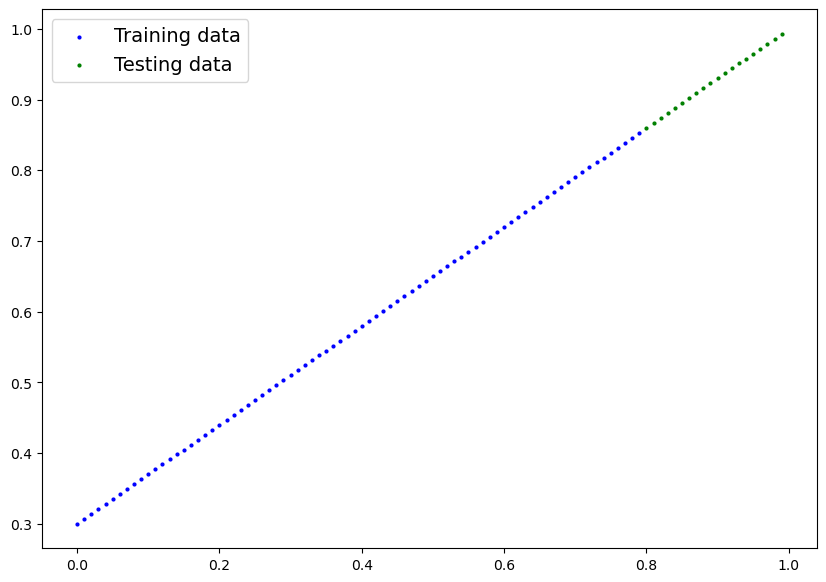

In [63]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

In [64]:
# adjust model_1 to fit the line
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [66]:
# loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [67]:
# train the model_2
torch.manual_seed(42)

# set the number of epochs
epochs = 1000

# put data to target device
X_train_regression = X_train_regression.to(device)
y_train_regression = y_train_regression.to(device)
X_test_regression = X_test_regression.to(device)
y_test_regression = y_test_regression.to(device)

for epoch in range(epochs):
    ### train mode
    # forward pass
    y_pred = model_2(X_train_regression)
    # calculate the loss
    loss = loss_fn(y_pred, y_train_regression)
    # optimizer zero grad
    optimizer.zero_grad()
    # Loss backwards
    loss.backward()
    # optimizer step
    optimizer.step()
    ### test mode
    model_2.eval()
    with torch.inference_mode():
        # forward pass
        test_pred = model_2(X_test_regression)
        # calculate the loss
        test_loss = loss_fn(test_pred, y_test_regression)
    if epoch % 100 == 0:
        print(f"Epoch:{epoch}|Train loss:{loss:.5f},Test loss:{test_loss:.5f}|")

Epoch:0|Train loss:0.75986,Test loss:0.54143|
Epoch:100|Train loss:0.09309,Test loss:0.02901|
Epoch:200|Train loss:0.07376,Test loss:0.02850|
Epoch:300|Train loss:0.06745,Test loss:0.00615|
Epoch:400|Train loss:0.06107,Test loss:0.02004|
Epoch:500|Train loss:0.05698,Test loss:0.01061|
Epoch:600|Train loss:0.04857,Test loss:0.01326|
Epoch:700|Train loss:0.06109,Test loss:0.02127|
Epoch:800|Train loss:0.05600,Test loss:0.01425|
Epoch:900|Train loss:0.05571,Test loss:0.00603|


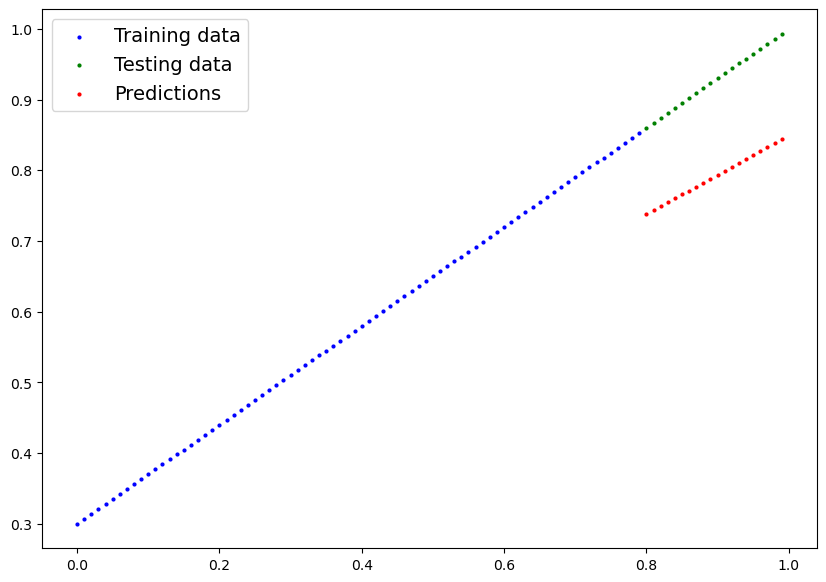

In [69]:
model_2.eval()
with torch.inference_mode():
    y_preds = model_2(X_test_regression)
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression,
                 predictions=y_preds.cpu())

In [70]:
# so the missing piece is non-linearity
# redo all the things above to fresh again!!
# experiment! experiment!! experiment!!!

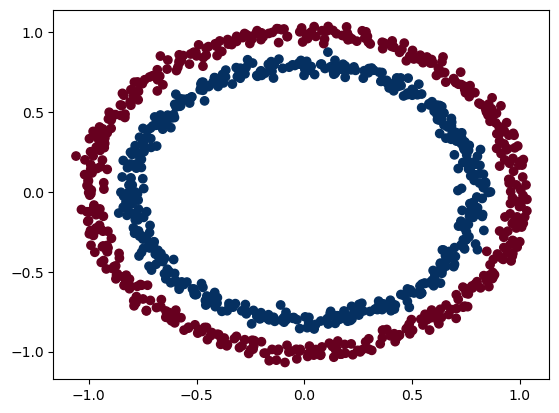

In [76]:
# make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
n_samples = 1000
X, y = make_circles(n_samples=n_samples,
                  noise=0.03,
                  random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [77]:
import torch
from sklearn.model_selection import train_test_split

# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [78]:
# build a model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [79]:
# setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [81]:
torch.manual_seed(42)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    if epoch % 100 == 0:
        print(f"Epoch:{epoch} | Loss:{loss:.5f} | Acc:{acc:.2f}% | Test loss:{test_loss:.5f}, Test acc:{test_acc:.2f}%")

Epoch:0 | Loss:0.69295 | Acc:50.00% | Test loss:0.69319, Test acc:50.00%
Epoch:100 | Loss:0.69115 | Acc:52.88% | Test loss:0.69102, Test acc:52.50%
Epoch:200 | Loss:0.68977 | Acc:53.37% | Test loss:0.68940, Test acc:55.00%
Epoch:300 | Loss:0.68795 | Acc:53.00% | Test loss:0.68723, Test acc:56.00%
Epoch:400 | Loss:0.68517 | Acc:52.75% | Test loss:0.68411, Test acc:56.50%
Epoch:500 | Loss:0.68102 | Acc:52.75% | Test loss:0.67941, Test acc:56.50%
Epoch:600 | Loss:0.67515 | Acc:54.50% | Test loss:0.67285, Test acc:56.00%
Epoch:700 | Loss:0.66659 | Acc:58.38% | Test loss:0.66322, Test acc:59.00%
Epoch:800 | Loss:0.65160 | Acc:64.00% | Test loss:0.64757, Test acc:67.50%
Epoch:900 | Loss:0.62362 | Acc:74.00% | Test loss:0.62145, Test acc:79.00%


In [83]:
# evaluate model 
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

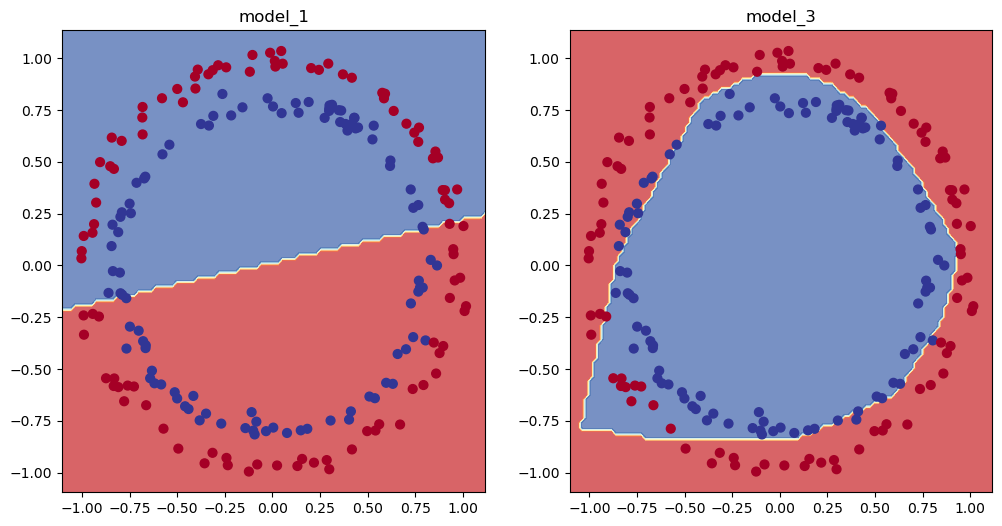

In [85]:
# plot decision boundaries for train and test datasets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("model_1")
plot_decision_boundary(model_1, X_test, y_test)
plt.subplot(1, 2, 2)
plt.title("model_3")
plot_decision_boundary(model_3, X_test, y_test)

### What is ReLU

In [86]:
# replicating non-linear activation functions
# create a toy tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

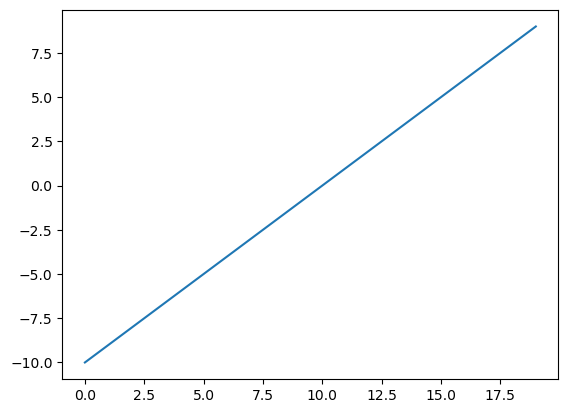

In [88]:
plt.plot(A);

In [89]:
# create a ReLU function by hand
def relu(x):
    return torch.maximum(torch.tensor(0), x)

# pass toy tensor through function
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

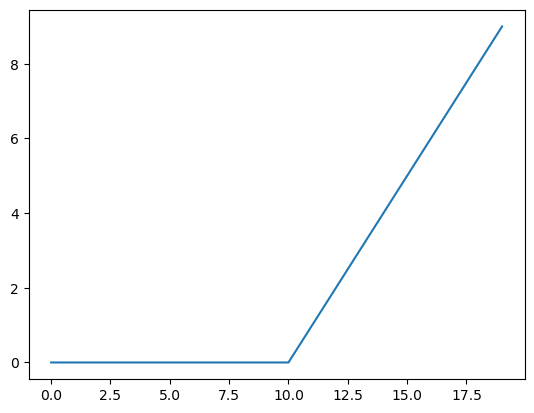

In [90]:
plt.plot(relu(A));

In [91]:
# sigmoid function
def sigmoid(x):
    return 1/ (1 + torch.exp(-x))

# pass toy tensor through function
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

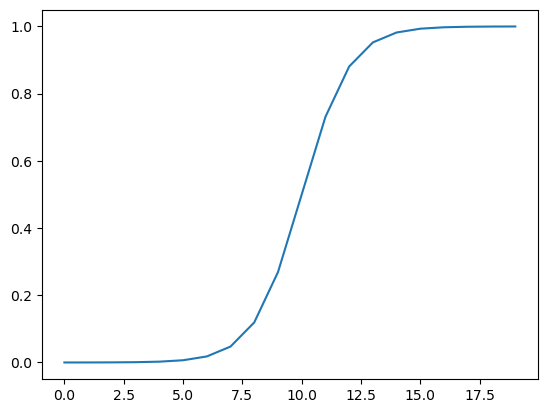

In [92]:
plt.plot(sigmoid(A));

### self experiment with sigmoid instead of relu

In [98]:
# build a model with non-linear activation function sigmoid
from torch import nn
class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.layer_3(self.sigmoid(self.layer_2(self.sigmoid(self.layer_1(x)))))

model_4 = CircleModelV3().to(device)
print(model_4)

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [99]:
# setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.01)

In [100]:
torch.manual_seed(42)
epochs = 10000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_4.train()

    y_logits = model_4(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    if epoch % 1000 == 0:
        print(f"Epoch:{epoch} | Loss:{loss:.5f} | Acc:{acc:.2f}% | Test loss:{test_loss:.5f}, Test acc:{test_acc:.2f}%")

Epoch:0 | Loss:0.69627 | Acc:50.00% | Test loss:0.69617, Test acc:50.00%
Epoch:1000 | Loss:0.69315 | Acc:50.62% | Test loss:0.69310, Test acc:50.50%
Epoch:2000 | Loss:0.69315 | Acc:50.25% | Test loss:0.69310, Test acc:49.50%
Epoch:3000 | Loss:0.69315 | Acc:50.50% | Test loss:0.69310, Test acc:49.00%
Epoch:4000 | Loss:0.69315 | Acc:50.62% | Test loss:0.69311, Test acc:48.00%
Epoch:5000 | Loss:0.69314 | Acc:50.25% | Test loss:0.69311, Test acc:48.00%
Epoch:6000 | Loss:0.69314 | Acc:50.38% | Test loss:0.69311, Test acc:49.00%
Epoch:7000 | Loss:0.69314 | Acc:50.25% | Test loss:0.69312, Test acc:50.50%
Epoch:8000 | Loss:0.69314 | Acc:49.75% | Test loss:0.69312, Test acc:50.50%
Epoch:9000 | Loss:0.69314 | Acc:49.62% | Test loss:0.69313, Test acc:52.00%


In [101]:
# evaluate model 
model_4.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_4(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 1., 1., 1., 0., 0., 0., 0., 1., 1.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

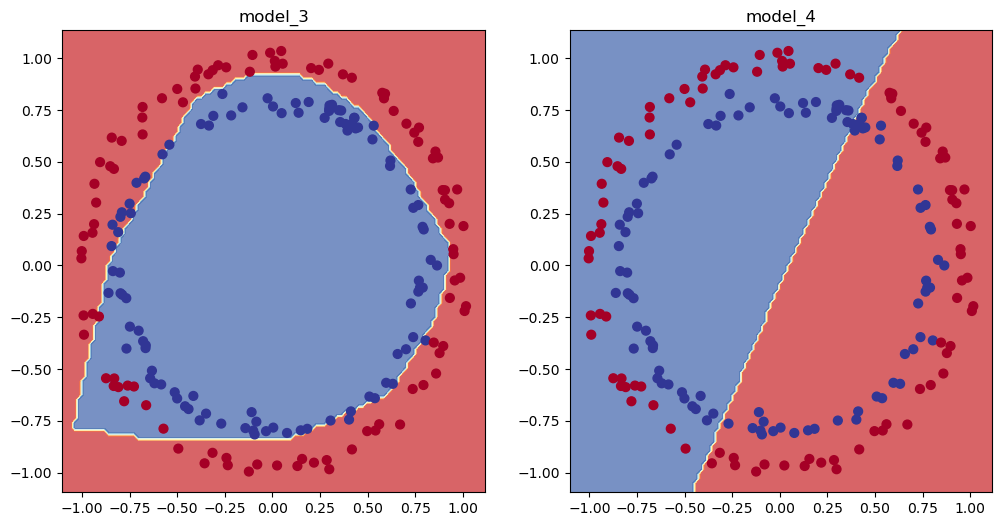

In [102]:
# plot decision boundaries for train and test datasets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("model_3")
plot_decision_boundary(model_3, X_test, y_test)
plt.subplot(1, 2, 2)
plt.title("model_4")
plot_decision_boundary(model_4, X_test, y_test)

看来不行，单独的sigmoid函数没有作用。

### Multi-class model

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


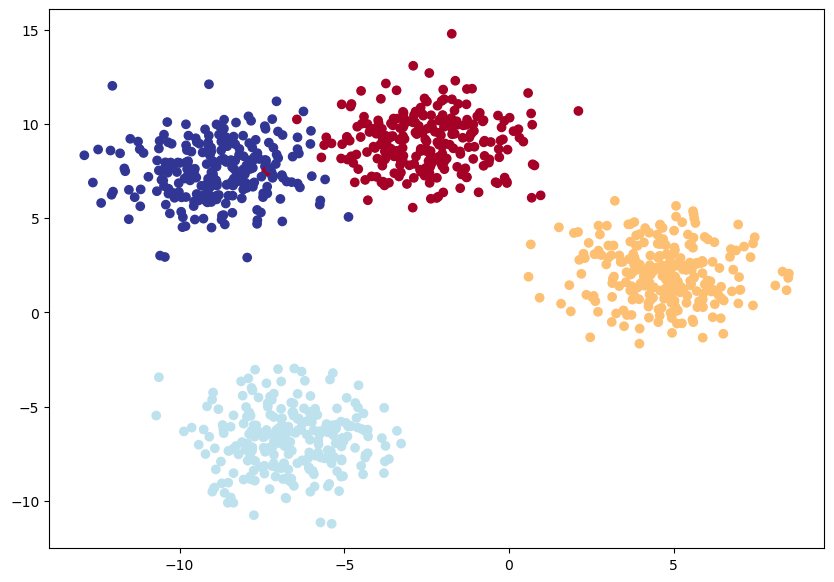

In [110]:
# create mutli class classification data
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# set parameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1, create data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2, turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3, split into train and test data
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4, plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [107]:
a = np.array([1, 2, 3])
torch.from_numpy(a).type(torch.float)

tensor([1., 2., 3.])